# An introduction to Felis and to cat qubits

Felis is the software solution we at Alice & Bob develop to let you experiment with our core technology, cat qubits.

It is based on Qiskit, the most popular quantum computing framework.

It features several backends emulating the properties of various real or fictitious chips, but it can also execute code on real hardware ([contact us](https://alice-bob.notion.site/Contact-us-901564d5bbb94066b2553b83ea4fe482) to learn more about that).

This introductory notebook will teach you how to work with cat qubits, assuming you are already familiar with Qiskit and superconducting qubits.

Full documentation is available at https://alice-bob.notion.site/alice-bob/Alice-Bob-Felis-documentation-52e554ccbea54e34831761f083883e49

## Your first logical circuit

Let us start by creating and measuring a Bell state on two logical qubits.

In [1]:
from qiskit_alice_bob_provider.local.provider import AliceBobLocalProvider
from qiskit import QuantumCircuit, execute
from qiskit.visualization import plot_histogram

shots = 10000
provider = AliceBobLocalProvider()

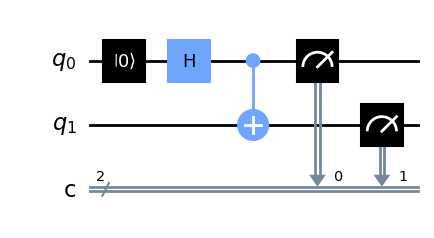

In [2]:
backend = provider.get_backend('EMU:15Q:LOGICAL_EARLY')

circ = QuantumCircuit(2,2)
circ.reset(0)
circ.h(0)
circ.cx(0,1)
circ.measure(0,0)
circ.measure(1,1)

circ.draw('mpl')

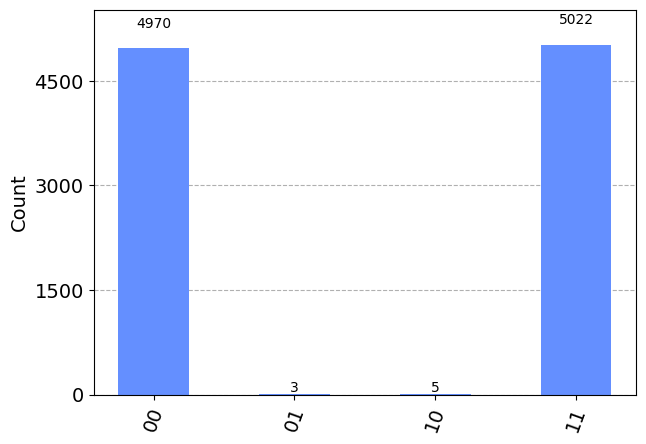

In [3]:
job = execute(circ, backend, shots=shots)
plot_histogram(job.result().get_counts())

In this example, we use the `EMU:15Q:LOGICAL_EARLY` backend, which anticipates what might be the performance of one of the first chips featuring a useful number of logical qubits (15, in this case). At the time when this tutorial is written (November 2023), such chips are expected to be only a few years in the future.

You can use this backend to run any quantum algorithm, like you would use virtually any other transmon-based backend. See notebooks \#4 and \#5 of this series for more examples.

But what are logical qubits, you may ask?

Logical qubits are an essential part of fault-tolerant quantum computers: they are error-corrected qubits built out of several physical qubits.

When you use the `EMU:15Q:LOGICAL_EARLY` backend, each qubit you declare in your circuit is a logical qubit. It is physically implemented by 13 "data" cat qubits (carrying the information of your logical qubit) and 12 "ancilla" cat qubits (used to perform error detection operations). Physical qubits are abstracted in this backend, but Felis makes it possible to work directly with physical qubits too (more on that in the second section on this notebook).

In `EMU:15Q:LOGICAL_EARLY`, we used fairly conservative hypotheses on the quality of the qubits involved, meaning you get error rates between 1e-3 and 1e-4 - this is better than any hardware available today, but not by a large margin.

Our goal being to reach very low error rates, we have created another backend using the hypotheses of our paper estimating we will need [60 times fewer qubits than a transmon-based architecture](https://arxiv.org/abs/2302.06639): `EMU:40Q:LOGICAL_TARGET`. It will take several more years after `EMU:15Q:LOGICAL_EARLY` to reach this level of performance. But it clearly illustrates the point of our approach: escape decoherence and get rid of noise!

As stated in the disclaimer below, the performance of these two backends does not represent a commitment by Alice & Bob.

## Your first physical circuit

Before we let you work with physical cat qubits, we need to bother you with a bit of theory.

First, let us remind you that there are two types of errors in quantum computers:
- Bit-flips (when $\ket{0}$ becomes $\ket{1}$ or the reverse)
- Phase-flips (when $\ket{+}$ becomes $\ket{-}$ or the reverse)

Using the `average_nb_photons` parameter, you can tune a cat qubit to exponentially remove bit-flips, while only linearly increasing phase-flips (see notebook #1 for a demonstration). This creates what we call a "noise bias".

Noise bias makes cat qubits a great building block for logical qubits, because bit-flips can be removed up to the point where only phase-flips remain to be corrected. This means the error correction code only needs to deal with phase-flips, which requires far fewer qubits. Indeed, we've shown that an an architecture based on cat qubits requires [60 times fewer qubits than a transmon-based architecture](https://arxiv.org/abs/2302.06639).

But this property also means that you can't just run any gate on a physical cat qubit without destroying its precious noise bias.

Let us learn to use physical cat qubits by running a simple phase-flip detection circuit.

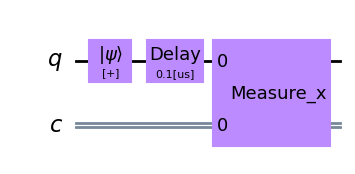

In [4]:
backend = provider.get_backend('EMU:1Q:LESCANNE_2020')

circ = QuantumCircuit(1, 1)
circ.initialize('+')
circ.delay(.1, 0, unit='us')
circ.measure_x(0, 0)

circ.draw('mpl')

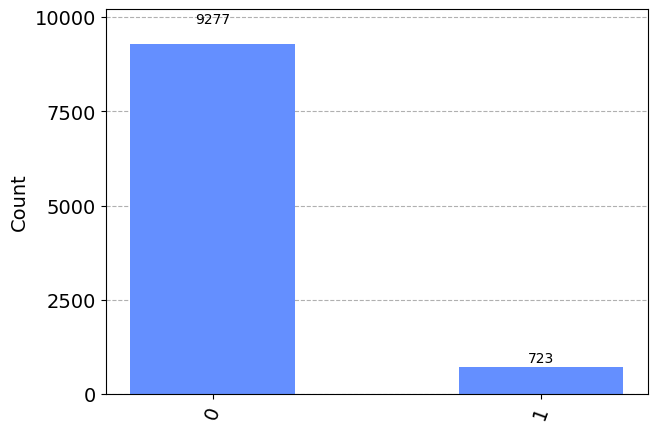

In [5]:
job = execute(circ, backend, shots=shots)
plot_histogram(job.result().get_counts())

The sample above uses the `EMU:1Q:LESCANNE_2020` backend, which reproduces results from the [seminal paper](https://arxiv.org/pdf/1907.11729.pdf) by Raphaël Lescanne.

In this sample, we measure the stability of the $\ket{+}$ state by waiting, then measuring the results along the X axis.

Note that you would do this slightly differently with a transmon qubit: 
* Instead of preparing the + state, you would prepare 0 and perform a Hadamard gate
* Instead of measuring along the X axis, you would perform an another Hadamard and measure along the Z axis

On cat qubits, preparing the $\ket{+}$ state and measuring along the X axis are native operations, so it is better to use them directly.

Moreover, the Hadamard gate is not supported. This is because the Hadamard gate can transform a phase-flip error into a bit-flip error, therefore destroying the noise bias. In other words, the Hadamard gate is not a "bias-preserving" gate.

Our physical cat qubits only support bias-preserving gates: X, Z, RZ, CNOT and delay. These gates are all you need to perform error correction experiments (see notebook #3 of this series for more details on this topic).

Because `EMU:1Q:LESCANNE_2020` reproduces the performance of a chip design dating back to 2019, we also provide better backends whose performance is closer to our most recent experimental results: `EMU:6Q:PHYSICAL_QUBITS` and `EMU:40Q:PHYSICAL_QUBITS`. However, as stated in the disclaimer below, their performance does not represent a commitment by Alice & Bob.

All our backends (physical and logical) can be tuned by using the following parameters:
* `average_nb_photons`, which defines the tradeoff between bit-flip and phase-flip errors (a higher value exponentially removes bit-flips, at the expense of a linear increase in phase-flips)
* `kappa_1` and `kappa_2`, which represent the performance of the cat qubits we use. Good cat qubits have a low `kappa_1` and a `high kappa_2`.

The logical backends `EMU:40Q:LOGICAL_TARGET` and `EMU:15Q:LOGICAL_EARLY` additionally support the `distance` parameter which controls the number of "data" physical qubits used in the error correction code forming a logical qubit.

Read more about these parameters and how to tune them at https://alice-bob.notion.site/Supported-instructions-f0fdeb8db5ed49f697a353a80203a449

## Disclaimer

Apart from `EMU:1Q:LESCANNE_2020`, none of the backends we provide is meant to accurately reproduce the performance of an actual or a planned chip.

The noise models use realistic hypotheses based on our theoretical works and our experimental progress, but they are still only projections of what might be available in the future and do not represent a commitment by Alice & Bob.

We are working on new models reproducing the performance of our current chips, and will update our provider and this notebook when they are ready.

## Go further!

This notebook comes with many others to dive deeper into use cases.

In case you only got this specific notebook, you can retrieve the whole series at https://github.com/Alice-Bob-SW/emulation-examples